# Analysis of Forensic AV LR/SLR Experiments

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KernelDensity
from sklearn.isotonic import IsotonicRegression

In [2]:
n_runs = 5

In [3]:
def log2(x):
    return np.log(x) / np.log(2)

def calc_log_lr_cost_vals(lr_same, lr_diff):
    return 0.5 * np.mean(log2(1 + 1/(lr_same))) + \
           0.5 * np.mean(log2(1 + lr_diff))

def calc_log_lr_cost(data, score_col): 

    if score_col == "count_lr":
        lr_same = np.exp(data[score_col][data['same_source']])
        lr_diff = np.exp(data[score_col][data['same_source']])
    else:
        lr_same = data[score_col][data['same_source']]
        lr_diff = data[score_col][~data['same_source']]
        
    return 0.5 * np.mean(log2(1 + 1/(lr_same))) + \
           0.5 * np.mean(log2(1 + lr_diff))

def calibrate(data, score_col):

    if score_col == "count_lr":
        pava = IsotonicRegression().fit(
            X=np.array(np.exp(data[score_col]), dtype='float128'), 
            y=np.array(data['same_source'])
        )
        post_prob = pava.predict(np.exp(data[score_col]))
    else:
        pava = IsotonicRegression().fit(
            X=np.array(data[score_col], dtype='float128'), 
            y=np.array(data['same_source'])
        )
        post_prob = pava.predict(data[score_col])

    n_s = sum(data['same_source'])
    n_d = sum(~data['same_source'])
    post_log_odds = np.log(post_prob) - np.log(1-post_prob)
    prior_log_odds = np.log(n_s/n_d)
    
    return post_log_odds - prior_log_odds

def calc_cllr_cal(data, score_col):
    cllr = calc_log_lr_cost(data, score_col)
    pav_lrs = np.exp(calibrate(data, score_col))
    ss_lrs_adj = pav_lrs[data["same_source"]]
    ds_lrs_adj = pav_lrs[~data["same_source"]]
    return cllr - calc_log_lr_cost_vals(ss_lrs_adj, ds_lrs_adj)

In [4]:
def get_metrics_for_dataset(dataset):
    test_files = ['./results/' + dataset + '_test' + str(i) + '.csv' for i in range(n_runs)]
    
    # store auc results
    luar_avg_aucs = []
    luar_tru_aucs = []
    cisr_avg_aucs = []
    cisr_tru_aucs = []
    znorm_aucs = []
    lex_aucs = []
    count_aucs = []

    # store cllr results
    luar_avg_cllrs = []
    luar_tru_cllrs = []
    cisr_avg_cllrs = []
    cisr_tru_cllrs = []
    znorm_cllrs = []
    lex_cllrs = []
    count_cllrs = []

    # store cllr_cal results
    luar_avg_cals = []
    luar_tru_cals = []
    cisr_avg_cals = []
    cisr_tru_cals = []
    znorm_cals = []
    lex_cals = []
    count_cals = []

    for f in test_files:
        lr_results = pd.read_csv(f)

        # calc auc
        luar_tru_aucs.append(roc_auc_score(lr_results.same_source, lr_results.luar_tru_lr))
        luar_avg_aucs.append(roc_auc_score(lr_results.same_source, lr_results.luar_avg_lr))
        cisr_tru_aucs.append(roc_auc_score(lr_results.same_source, lr_results.cisr_tru_lr))
        cisr_avg_aucs.append(roc_auc_score(lr_results.same_source, lr_results.cisr_avg_lr))
        znorm_aucs.append(roc_auc_score(lr_results.same_source, lr_results.znorm_lr))
        lex_aucs.append(roc_auc_score(lr_results.same_source, lr_results.lex_lr))
        count_aucs.append(roc_auc_score(lr_results.same_source, lr_results.count_lr))

        # calc_cllr
        luar_avg_cllrs.append(calc_log_lr_cost(lr_results, 'luar_avg_lr'))
        luar_tru_cllrs.append(calc_log_lr_cost(lr_results, 'luar_tru_lr'))
        cisr_avg_cllrs.append(calc_log_lr_cost(lr_results, 'cisr_avg_lr'))
        cisr_tru_cllrs.append(calc_log_lr_cost(lr_results, 'cisr_tru_lr'))
        znorm_cllrs.append(calc_log_lr_cost(lr_results, 'znorm_lr'))
        lex_cllrs.append(calc_log_lr_cost(lr_results, 'lex_lr'))
        count_cllrs.append(calc_log_lr_cost(lr_results, 'count_lr'))

        # calc_cllr_cal
        luar_avg_cals.append(calc_cllr_cal(lr_results, 'luar_avg_lr'))
        luar_tru_cals.append(calc_cllr_cal(lr_results, 'luar_tru_lr'))
        cisr_avg_cals.append(calc_cllr_cal(lr_results, 'cisr_avg_lr'))
        cisr_tru_cals.append(calc_cllr_cal(lr_results, 'cisr_tru_lr'))
        znorm_cals.append(calc_cllr_cal(lr_results, 'znorm_lr'))
        lex_cals.append(calc_cllr_cal(lr_results, 'lex_lr'))
        count_cals.append(calc_cllr_cal(lr_results, 'count_lr'))
    
    results_dict = {
        'auc': {
            'luar_tru': luar_tru_aucs,
            'luar_avg': luar_avg_aucs,
            'cisr_tru': cisr_tru_aucs,
            'cisr_avg': cisr_avg_aucs,
            'znorm': znorm_aucs,
            'lex': lex_aucs,
            'count': count_aucs
        },
        'cllr': {
            'luar_tru': luar_tru_cllrs,
            'luar_avg': luar_avg_cllrs,
            'cisr_tru': cisr_tru_cllrs,
            'cisr_avg': cisr_avg_cllrs,
            'znorm': znorm_cllrs,
            'lex': lex_cllrs,
            'count': count_cllrs
        },
        'cllr_cal' :{
            'luar_tru': luar_tru_cals,
            'luar_avg': luar_avg_cals,
            'cisr_tru': cisr_tru_cals,
            'cisr_avg': cisr_avg_cals,
            'znorm': znorm_cals,
            'lex': lex_cals,
            'count': count_cals
        }
    }

    return results_dict

In [5]:
dr = get_metrics_for_dataset("darkreddit")
sr = get_metrics_for_dataset("silkroad")
ag = get_metrics_for_dataset("agora")
am = get_metrics_for_dataset("amazon")

/var/folders/sc/z0jqbpxs1tv0nqnbmj49gmpr0000gn/T/ipykernel_57283/4140161900.py:37: RuntimeWarning: divide by zero encountered in log
  post_log_odds = np.log(post_prob) - np.log(1-post_prob)
/var/folders/sc/z0jqbpxs1tv0nqnbmj49gmpr0000gn/T/ipykernel_57283/4140161900.py:37: RuntimeWarning: divide by zero encountered in log
  post_log_odds = np.log(post_prob) - np.log(1-post_prob)
/var/folders/sc/z0jqbpxs1tv0nqnbmj49gmpr0000gn/T/ipykernel_57283/4140161900.py:37: RuntimeWarning: divide by zero encountered in log
  post_log_odds = np.log(post_prob) - np.log(1-post_prob)
/var/folders/sc/z0jqbpxs1tv0nqnbmj49gmpr0000gn/T/ipykernel_57283/4140161900.py:37: RuntimeWarning: divide by zero encountered in log
  post_log_odds = np.log(post_prob) - np.log(1-post_prob)
/var/folders/sc/z0jqbpxs1tv0nqnbmj49gmpr0000gn/T/ipykernel_57283/4140161900.py:37: RuntimeWarning: divide by zero encountered in log
  post_log_odds = np.log(post_prob) - np.log(1-post_prob)
/var/folders/sc/z0jqbpxs1tv0nqnbmj49gmpr0000g

In [7]:
def create_metric_table(metric):
    return pd.DataFrame({
    "Method": ["LUAR TRU SLR", "LUAR AVG SLR", "CISR TRU SLR", "CISR AVG SLR", "Bag-of-words SLR", "Lexical SLR", "Bag-of-words MultiDir LR"],
    "DarkReddit": [np.mean(vals) for vals in dr[metric].values()],
    "SilkRoad": [np.mean(vals) for vals in sr[metric].values()],
    "Agora": [np.mean(vals) for vals in ag[metric].values()],
    "Amazon": [np.mean(vals) for vals in am[metric].values()]
})

In [8]:
print(create_metric_table('auc').style.hide().highlight_max(axis=0, props="font-weight:bold;").format(precision=2).to_latex(convert_css=True))

\begin{tabular}{lrrrr}
Method & DarkReddit & SilkRoad & Agora & Amazon \\
LUAR TRU SLR & 0.87 & \bfseries 0.79 & 0.76 & 0.92 \\
LUAR AVG SLR & \bfseries 0.87 & 0.79 & 0.75 & \bfseries 0.95 \\
CISR TRU SLR & 0.79 & 0.74 & \bfseries 0.80 & 0.83 \\
CISR AVG SLR & 0.79 & 0.74 & 0.79 & 0.88 \\
Bag-of-words SLR & 0.62 & 0.57 & 0.60 & 0.82 \\
\bfseries Lexical SLR & 0.61 & 0.59 & 0.60 & 0.72 \\
Bag-of-words MultiDir LR & 0.65 & 0.63 & 0.67 & 0.85 \\
\end{tabular}



In [9]:
print(create_metric_table('cllr').style.hide().highlight_min(axis=0, props="font-weight:bold;").format(precision=2).to_latex(convert_css=True))

\begin{tabular}{lrrrr}
Method & DarkReddit & SilkRoad & Agora & Amazon \\
LUAR TRU SLR & 0.67 & \bfseries 0.79 & 0.86 & 0.57 \\
LUAR AVG SLR & \bfseries 0.67 & 0.79 & 0.87 & \bfseries 0.47 \\
CISR TRU SLR & 0.81 & 0.87 & \bfseries 0.80 & 0.74 \\
CISR AVG SLR & 0.79 & 0.86 & 0.81 & 0.66 \\
Bag-of-words SLR & 0.96 & 0.99 & 0.98 & 0.76 \\
Lexical SLR & 0.96 & 0.98 & 0.98 & 0.89 \\
\bfseries Bag-of-words MultiDir LR & 7.84 & 2.32 & 2.71 & 8.92 \\
\end{tabular}



In [10]:
print(create_metric_table('cllr_cal').style.hide().highlight_min(axis=0, props="font-weight:bold;").format(precision=2).to_latex(convert_css=True))

\begin{tabular}{lrrrr}
Method & DarkReddit & SilkRoad & Agora & Amazon \\
LUAR TRU SLR & 0.04 & 0.03 & 0.04 & 0.10 \\
LUAR AVG SLR & 0.04 & 0.03 & 0.05 & 0.11 \\
CISR TRU SLR & 0.04 & 0.04 & 0.04 & 0.05 \\
CISR AVG SLR & 0.03 & 0.03 & 0.04 & 0.07 \\
Bag-of-words SLR & \bfseries 0.02 & \bfseries 0.01 & 0.03 & 0.05 \\
Lexical SLR & 0.02 & 0.01 & \bfseries 0.03 & \bfseries 0.04 \\
\bfseries Bag-of-words MultiDir LR & 6.93 & 1.38 & 1.81 & 8.27 \\
\end{tabular}



In [11]:
combined_cal_table = pd.DataFrame({
    "Method": ["LUAR TRU SLR", "LUAR AVG SLR", "CISR TRU SLR", "CISR AVG SLR", "Bag-of-words SLR", "Lexical SLR", "Bag-of-words MultiDir LR"],
    "DarkReddit - Cllr": [np.mean(vals) for vals in dr["cllr"].values()],
    "DarkReddit - Cllr_cal": [np.mean(vals) for vals in dr["cllr_cal"].values()],
    "SilkRoad - Cllr": [np.mean(vals) for vals in sr["cllr"].values()],
    "SilkRoad - Cllr_cal": [np.mean(vals) for vals in sr["cllr_cal"].values()],
    "Agora - Cllr": [np.mean(vals) for vals in ag["cllr"].values()],
    "Agora - Cllr_cal": [np.mean(vals) for vals in ag["cllr_cal"].values()],
    "Amazon - Cllr": [np.mean(vals) for vals in am["cllr"].values()],
    "Amazon - Cllr_cal": [np.mean(vals) for vals in am["cllr_cal"].values()]
})

In [12]:
print(combined_cal_table.style.hide().highlight_min(axis=0, props="font-weight:bold;").format(precision=2).to_latex(convert_css=True))

\begin{tabular}{lrrrrrrrr}
Method & DarkReddit - Cllr & DarkReddit - Cllr_cal & SilkRoad - Cllr & SilkRoad - Cllr_cal & Agora - Cllr & Agora - Cllr_cal & Amazon - Cllr & Amazon - Cllr_cal \\
LUAR TRU SLR & 0.67 & 0.04 & \bfseries 0.79 & 0.03 & 0.86 & 0.04 & 0.57 & 0.10 \\
LUAR AVG SLR & \bfseries 0.67 & 0.04 & 0.79 & 0.03 & 0.87 & 0.05 & \bfseries 0.47 & 0.11 \\
CISR TRU SLR & 0.81 & 0.04 & 0.87 & 0.04 & \bfseries 0.80 & 0.04 & 0.74 & 0.05 \\
CISR AVG SLR & 0.79 & 0.03 & 0.86 & 0.03 & 0.81 & 0.04 & 0.66 & 0.07 \\
Bag-of-words SLR & 0.96 & \bfseries 0.02 & 0.99 & \bfseries 0.01 & 0.98 & 0.03 & 0.76 & 0.05 \\
Lexical SLR & 0.96 & 0.02 & 0.98 & 0.01 & 0.98 & \bfseries 0.03 & 0.89 & \bfseries 0.04 \\
\bfseries Bag-of-words MultiDir LR & 7.84 & 6.93 & 2.32 & 1.38 & 2.71 & 1.81 & 8.92 & 8.27 \\
\end{tabular}



In [13]:
def get_interpret_summaries(df, score_col):
    n_s = len(df[score_col][df.same_source])
    n_d = len(df[score_col][~df.same_source])

    sum_dict = {
        'ss_g10': np.sum(df[score_col][df.same_source] >=10)/n_s,
        'ss_g1': np.sum((df[score_col][df.same_source] < 10) & (df[score_col][df.same_source] >= 1))/n_s,
        'ss_l1': np.sum((df[score_col][df.same_source] < 1) & (df[score_col][df.same_source] >= 1/10))/n_s,
        'ss_l01': np.sum(df[score_col][df.same_source] < 1/10)/n_s,
        'ds_g10': np.sum(df[score_col][~df.same_source] >=10)/n_d,
        'ds_g1': np.sum((df[score_col][~df.same_source] < 10) & (df[score_col][~df.same_source] >= 1))/n_d,
        'ds_l1': np.sum((df[score_col][~df.same_source] < 1) & (df[score_col][~df.same_source] >= 1/10))/n_d,
        'ds_l01': np.sum(df[score_col][~df.same_source] < 1/10)/n_d,
    }
    return sum_dict

In [14]:
def get_interpret_summaries_for_dataset(dataset):
    test_files = ['./results/' + dataset + '_test' + str(i) + '.csv' for i in range(n_runs)]

    luar_dicts = []
    cisr_dicts = []
    znorm_dicts = []
    lex_dicts = []
    count_dicts = []
    

    for f in test_files:
        lr_results = pd.read_csv(f)

        if dataset == "amazon":
            luar_dicts.append(get_interpret_summaries(lr_results, 'luar_avg_lr'))
            cisr_dicts.append(get_interpret_summaries(lr_results, 'cisr_avg_lr'))
        else:
            luar_dicts.append(get_interpret_summaries(lr_results, 'luar_tru_lr'))
            cisr_dicts.append(get_interpret_summaries(lr_results, 'cisr_tru_lr'))

        znorm_dicts.append(get_interpret_summaries(lr_results, 'znorm_lr'))
        lex_dicts.append(get_interpret_summaries(lr_results, 'lex_lr'))
        count_dicts.append(get_interpret_summaries(lr_results, 'count_lr'))
    
    
    results_dict = {
        'luar': luar_dicts,
        'cisr': cisr_dicts,
        'znorm': znorm_dicts,
        'lex': lex_dicts,
        'count': count_dicts
    }

    return results_dict

In [15]:
def aggregate_summaries(sum_dict):
    agg_dict = {
        "Method": ["LUAR SLR", "CISR SLR", "Bag-of-words SLR", "Lexical SLR", "Bag-of-words MultiDir LR"],
        "DS < 1/10": [
            np.mean([item['ds_l01'] for item in sum_dict['luar']]),
            np.mean([item['ds_l01'] for item in sum_dict['cisr']]),
            np.mean([item['ds_l01'] for item in sum_dict['znorm']]),
            np.mean([item['ds_l01'] for item in sum_dict['lex']]),
            np.mean([item['ds_l01'] for item in sum_dict['count']])
        ],
        "1/10 < DS < 1": [
            np.mean([item['ds_l1'] for item in sum_dict['luar']]),
            np.mean([item['ds_l1'] for item in sum_dict['cisr']]),
            np.mean([item['ds_l1'] for item in sum_dict['znorm']]),
            np.mean([item['ds_l1'] for item in sum_dict['lex']]),
            np.mean([item['ds_l1'] for item in sum_dict['count']])
        ],
        "1 < DS < 10": [
            np.mean([item['ds_g1'] for item in sum_dict['luar']]),
            np.mean([item['ds_g1'] for item in sum_dict['cisr']]),
            np.mean([item['ds_g1'] for item in sum_dict['znorm']]),
            np.mean([item['ds_g1'] for item in sum_dict['lex']]),
            np.mean([item['ds_g1'] for item in sum_dict['count']])
        ],
        "DS > 10": [
            np.mean([item['ds_g10'] for item in sum_dict['luar']]),
            np.mean([item['ds_g10'] for item in sum_dict['cisr']]),
            np.mean([item['ds_g10'] for item in sum_dict['znorm']]),
            np.mean([item['ds_g10'] for item in sum_dict['lex']]),
            np.mean([item['ds_g10'] for item in sum_dict['count']])
        ],
        "SS < 1/10": [
            np.mean([item['ss_l01'] for item in sum_dict['luar']]),
            np.mean([item['ss_l01'] for item in sum_dict['cisr']]),
            np.mean([item['ss_l01'] for item in sum_dict['znorm']]),
            np.mean([item['ss_l01'] for item in sum_dict['lex']]),
            np.mean([item['ss_l01'] for item in sum_dict['count']])
        ],
        "1/10 < SS < 1": [
            np.mean([item['ss_l1'] for item in sum_dict['luar']]),
            np.mean([item['ss_l1'] for item in sum_dict['cisr']]),
            np.mean([item['ss_l1'] for item in sum_dict['znorm']]),
            np.mean([item['ss_l1'] for item in sum_dict['lex']]),
            np.mean([item['ss_l1'] for item in sum_dict['count']])
        ],
        "1 < SS < 10": [
            np.mean([item['ss_g1'] for item in sum_dict['luar']]),
            np.mean([item['ss_g1'] for item in sum_dict['cisr']]),
            np.mean([item['ss_g1'] for item in sum_dict['znorm']]),
            np.mean([item['ss_g1'] for item in sum_dict['lex']]),
            np.mean([item['ss_g1'] for item in sum_dict['count']])
        ],
        "SS > 10": [
            np.mean([item['ss_g10'] for item in sum_dict['luar']]),
            np.mean([item['ss_g10'] for item in sum_dict['cisr']]),
            np.mean([item['ss_g10'] for item in sum_dict['znorm']]),
            np.mean([item['ss_g10'] for item in sum_dict['lex']]),
            np.mean([item['ss_g10'] for item in sum_dict['count']])
        ]
    }

    return pd.DataFrame(agg_dict)

In [16]:
dr_summary = get_interpret_summaries_for_dataset("darkreddit")
sr_summary = get_interpret_summaries_for_dataset("silkroad")
ag_summary = get_interpret_summaries_for_dataset("agora")
am_summary = get_interpret_summaries_for_dataset("amazon")
aggregate_summaries(dr_summary)

,Method,DS < 1/10,1/10 < DS < 1,1 < DS < 10,DS > 10,SS < 1/10,1/10 < SS < 1,1 < SS < 10,SS > 10
0,LUAR SLR,0.0208,0.7368,0.2360,0.0064,0.0016,0.1976,0.5008,0.3000
1,CISR SLR,0.0704,0.6196,0.3100,0.0000,0.0108,0.2368,0.7460,0.0064
2,Bag-of-words SLR,0.0000,0.6328,0.3668,0.0004,0.0008,0.4636,0.4720,0.0636
3,Lexical SLR,0.0000,0.6188,0.3812,0.0000,0.0000,0.4584,0.5416,0.0000
4,Bag-of-words MultiDir LR,0.8036,0.1160,0.0796,0.0008,0.5828,0.1364,0.2128,0.0680


In [17]:
print(aggregate_summaries(dr_summary).style.format(precision=2).hide().to_latex(convert_css=False))

\begin{tabular}{lrrrrrrrr}
Method & DS < 1/10 & 1/10 < DS < 1 & 1 < DS < 10 & DS > 10 & SS < 1/10 & 1/10 < SS < 1 & 1 < SS < 10 & SS > 10 \\
LUAR SLR & 0.02 & 0.74 & 0.24 & 0.01 & 0.00 & 0.20 & 0.50 & 0.30 \\
CISR SLR & 0.07 & 0.62 & 0.31 & 0.00 & 0.01 & 0.24 & 0.75 & 0.01 \\
Bag-of-words SLR & 0.00 & 0.63 & 0.37 & 0.00 & 0.00 & 0.46 & 0.47 & 0.06 \\
Lexical SLR & 0.00 & 0.62 & 0.38 & 0.00 & 0.00 & 0.46 & 0.54 & 0.00 \\
Bag-of-words MultiDir LR & 0.80 & 0.12 & 0.08 & 0.00 & 0.58 & 0.14 & 0.21 & 0.07 \\
\end{tabular}



In [18]:
print(aggregate_summaries(sr_summary).style.format(precision=2).hide().to_latex(convert_css=False))

\begin{tabular}{lrrrrrrrr}
Method & DS < 1/10 & 1/10 < DS < 1 & 1 < DS < 10 & DS > 10 & SS < 1/10 & 1/10 < SS < 1 & 1 < SS < 10 & SS > 10 \\
LUAR SLR & 0.04 & 0.74 & 0.21 & 0.01 & 0.00 & 0.34 & 0.54 & 0.12 \\
CISR SLR & 0.06 & 0.64 & 0.30 & 0.00 & 0.01 & 0.35 & 0.65 & 0.00 \\
Bag-of-words SLR & 0.00 & 0.55 & 0.45 & 0.00 & 0.00 & 0.45 & 0.55 & 0.00 \\
Lexical SLR & 0.00 & 0.63 & 0.37 & 0.00 & 0.00 & 0.51 & 0.49 & 0.00 \\
Bag-of-words MultiDir LR & 0.80 & 0.10 & 0.10 & 0.00 & 0.63 & 0.15 & 0.22 & 0.01 \\
\end{tabular}



In [19]:
print(aggregate_summaries(ag_summary).style.format(precision=2).hide().to_latex(convert_css=False))

\begin{tabular}{lrrrrrrrr}
Method & DS < 1/10 & 1/10 < DS < 1 & 1 < DS < 10 & DS > 10 & SS < 1/10 & 1/10 < SS < 1 & 1 < SS < 10 & SS > 10 \\
LUAR SLR & 0.01 & 0.69 & 0.30 & 0.01 & 0.00 & 0.30 & 0.68 & 0.03 \\
CISR SLR & 0.05 & 0.63 & 0.32 & 0.00 & 0.00 & 0.22 & 0.78 & 0.00 \\
Bag-of-words SLR & 0.00 & 0.53 & 0.47 & 0.00 & 0.00 & 0.38 & 0.61 & 0.01 \\
Lexical SLR & 0.00 & 0.68 & 0.32 & 0.00 & 0.00 & 0.55 & 0.45 & 0.00 \\
Bag-of-words MultiDir LR & 0.84 & 0.08 & 0.08 & 0.00 & 0.63 & 0.12 & 0.24 & 0.02 \\
\end{tabular}



In [20]:
print(aggregate_summaries(am_summary).style.format(precision=2).hide().to_latex(convert_css=False))

\begin{tabular}{lrrrrrrrr}
Method & DS < 1/10 & 1/10 < DS < 1 & 1 < DS < 10 & DS > 10 & SS < 1/10 & 1/10 < SS < 1 & 1 < SS < 10 & SS > 10 \\
LUAR SLR & 0.54 & 0.38 & 0.08 & 0.01 & 0.03 & 0.11 & 0.29 & 0.57 \\
CISR SLR & 0.37 & 0.38 & 0.25 & 0.00 & 0.02 & 0.14 & 0.85 & 0.00 \\
Bag-of-words SLR & 0.09 & 0.66 & 0.24 & 0.00 & 0.01 & 0.25 & 0.60 & 0.14 \\
Lexical SLR & 0.00 & 0.68 & 0.32 & 0.00 & 0.00 & 0.36 & 0.64 & 0.00 \\
Bag-of-words MultiDir LR & 0.99 & 0.00 & 0.01 & 0.00 & 0.73 & 0.03 & 0.16 & 0.08 \\
\end{tabular}



## KDEs

In [21]:
def plot_density(ax, ss_scores, ds_scores, model_name, n_hist_bins=32, n_kde_bins=1000, alpha=0.5, ss_color='red', ds_color='blue', ss_label='same source', ds_label='diff source', legend=False):
    x_min = min(ss_scores) - 0.05
    x_max = max(ds_scores) + 0.05

    n = len(ss_scores)
    iqr_ss = np.quantile(ss_scores, 0.75) - np.quantile(ss_scores, 0.25)
    b_ss = min(np.std(ss_scores), iqr_ss/1.34)
    iqr_ds = np.quantile(ds_scores, 0.75) - np.quantile(ds_scores, 0.25)
    b_ds = min(np.std(ds_scores), iqr_ds/1.34)
    ss_bw = 0.9*b_ss*n**(-1/5)
    ds_bw = 0.9*b_ds*n**(-1/5)

    ss_kde = KernelDensity(kernel="gaussian", bandwidth=ss_bw).fit(np.array(ss_scores)[:, np.newaxis])
    ds_kde = KernelDensity(kernel="gaussian", bandwidth=ds_bw).fit(np.array(ds_scores)[:, np.newaxis])
    
    bins = np.linspace(x_min, x_max, n_hist_bins)
    kde_bins = np.linspace(x_min, x_max, n_kde_bins)

    # get the log densities
    ss_log_dens = ss_kde.score_samples(kde_bins[:, np.newaxis])
    ds_log_dens = ds_kde.score_samples(kde_bins[:, np.newaxis])

    ax.hist(ss_scores, bins, alpha=alpha, color=ss_color, label=ss_label, edgecolor=ss_color, density=True)
    ax.hist(ds_scores, bins, alpha=alpha, color=ds_color, label=ds_label, edgecolor=ds_color, density=True)
    if legend:
        ax.legend(loc = 'best')
    ax.plot(kde_bins, np.exp(ss_log_dens), lw = 2, linestyle = "-", color=ss_color)
    ax.plot(kde_bins, np.exp(ds_log_dens), lw = 2, linestyle = "-", color=ds_color)
    ax.set_xlabel('Cosine Distance')
    ax.set_ylabel('Density')
    ax.set_title(model_name)

In [22]:
run_num = 0

In [23]:
dr_train_scores = pd.read_csv('./results/darkreddit_train' + str(run_num) + '.csv')
sr_train_scores = pd.read_csv('./results/silkroad_train' + str(run_num) + '.csv')
ag_train_scores = pd.read_csv('./results/agora_train' + str(run_num) + '.csv')
am_train_scores = pd.read_csv('./results/amazon_train' + str(run_num) + '.csv')

In [24]:
dr_train_scores

,problem_id,same_source,luar_avg_score,luar_tru_score,cisr_avg_score,cisr_tru_score,znorm_score,lex_score
0,11baeea6-d774-11ec-9b41-992cfacb18f3,True,0.439421,0.439421,1.433930,1.433930,0.940060,1.460376
1,116a700c-d774-11ec-9b41-992cfacb18f3,True,0.523322,0.523322,0.247445,0.247445,0.993295,0.365169
2,116bd032-d774-11ec-9b41-992cfacb18f3,True,0.343781,0.343781,0.269364,0.269364,1.024412,0.802021
3,11819a8e-d774-11ec-9b41-992cfacb18f3,True,0.620689,0.620689,1.081958,0.699762,0.749238,0.779388
4,11c497bc-d774-11ec-9b41-992cfacb18f3,True,0.587646,0.587646,0.789083,0.798297,1.020107,1.141519
...,...,...,...,...,...,...,...,...
1995,11c7fe0c-d774-11ec-9b41-992cfacb18f3,False,0.573204,0.526860,0.296964,0.256042,1.297243,0.965767
1996,11caeee6-d774-11ec-9b41-992cfacb18f3,False,0.600501,0.600501,1.520514,1.492196,1.140087,1.337348
1997,115070e4-d774-11ec-9b41-992cfacb18f3,False,0.572816,0.572816,1.045119,1.045119,1.075347,1.091000
1998,11a92bd0-d774-11ec-9b41-992cfacb18f3,False,0.467158,0.467158,0.952986,0.952986,0.990629,0.562300


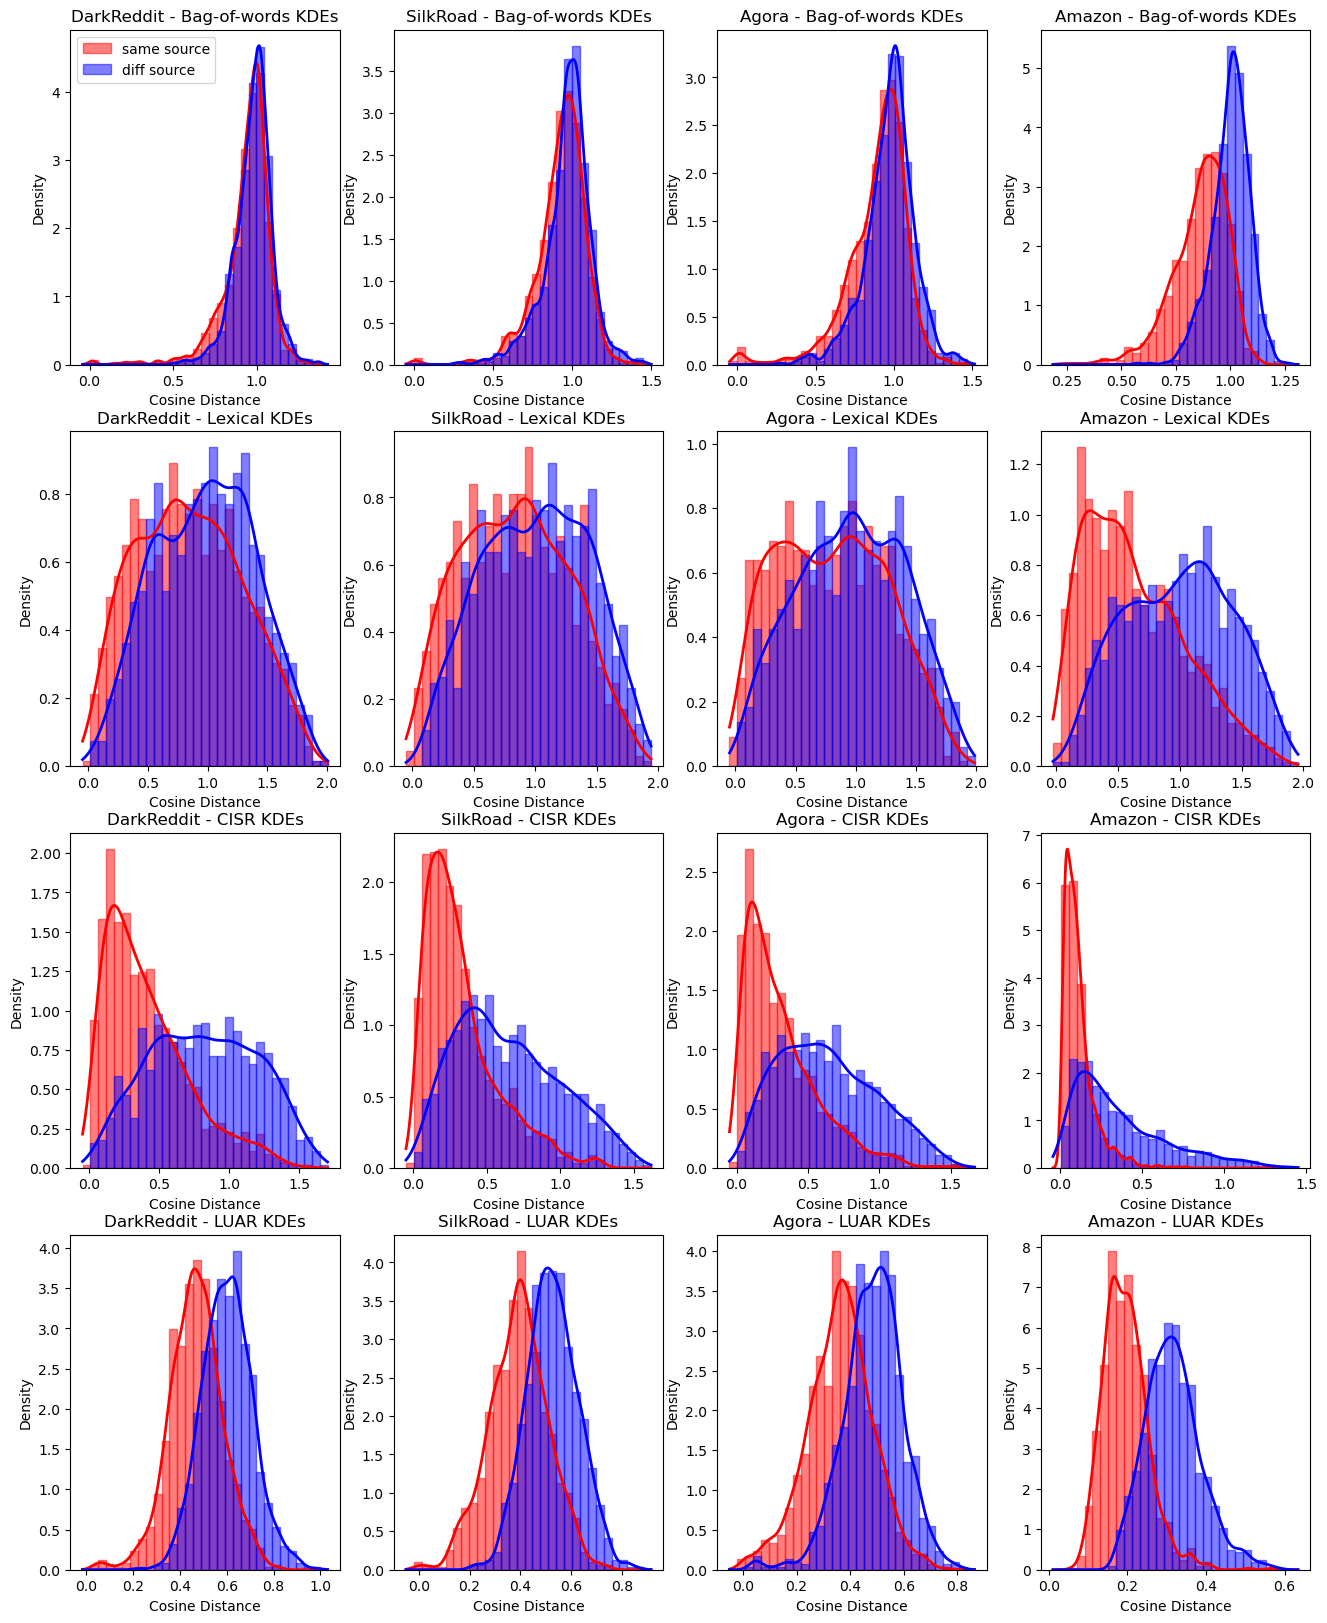

In [26]:
fig, ax = plt.subplots(4, 4, figsize=(16, 20))
plot_density(ax[3,0], dr_train_scores.luar_tru_score[dr_train_scores.same_source], dr_train_scores.luar_tru_score[~dr_train_scores.same_source], 'DarkReddit - LUAR KDEs')
plot_density(ax[2,0], dr_train_scores.cisr_tru_score[dr_train_scores.same_source], dr_train_scores.cisr_tru_score[~dr_train_scores.same_source], 'DarkReddit - CISR KDEs')
plot_density(ax[0,0], dr_train_scores.znorm_score[dr_train_scores.same_source], dr_train_scores.znorm_score[~dr_train_scores.same_source], 'DarkReddit - Bag-of-words KDEs', legend=True)
plot_density(ax[1,0], dr_train_scores.lex_score[dr_train_scores.same_source], dr_train_scores.lex_score[~dr_train_scores.same_source], 'DarkReddit - Lexical KDEs')
plot_density(ax[3,1], sr_train_scores.luar_tru_score[sr_train_scores.same_source], sr_train_scores.luar_tru_score[~sr_train_scores.same_source], 'SilkRoad - LUAR KDEs')
plot_density(ax[2,1], sr_train_scores.cisr_tru_score[sr_train_scores.same_source], sr_train_scores.cisr_tru_score[~sr_train_scores.same_source], 'SilkRoad - CISR KDEs')
plot_density(ax[0,1], sr_train_scores.znorm_score[sr_train_scores.same_source], sr_train_scores.znorm_score[~sr_train_scores.same_source], 'SilkRoad - Bag-of-words KDEs')
plot_density(ax[1,1], sr_train_scores.lex_score[sr_train_scores.same_source], sr_train_scores.lex_score[~sr_train_scores.same_source], 'SilkRoad - Lexical KDEs')
plot_density(ax[3,2], ag_train_scores.luar_tru_score[ag_train_scores.same_source], ag_train_scores.luar_tru_score[~ag_train_scores.same_source], 'Agora - LUAR KDEs')
plot_density(ax[2,2], ag_train_scores.cisr_tru_score[ag_train_scores.same_source], ag_train_scores.cisr_tru_score[~ag_train_scores.same_source], 'Agora - CISR KDEs')
plot_density(ax[0,2], ag_train_scores.znorm_score[ag_train_scores.same_source], ag_train_scores.znorm_score[~ag_train_scores.same_source], 'Agora - Bag-of-words KDEs')
plot_density(ax[1,2], ag_train_scores.lex_score[ag_train_scores.same_source], ag_train_scores.lex_score[~ag_train_scores.same_source], 'Agora - Lexical KDEs')
plot_density(ax[3,3], am_train_scores.luar_tru_score[am_train_scores.same_source], am_train_scores.luar_tru_score[~am_train_scores.same_source], 'Amazon - LUAR KDEs')
plot_density(ax[2,3], am_train_scores.cisr_tru_score[am_train_scores.same_source], am_train_scores.cisr_tru_score[~am_train_scores.same_source], 'Amazon - CISR KDEs')
plot_density(ax[0,3], am_train_scores.znorm_score[am_train_scores.same_source], am_train_scores.znorm_score[~am_train_scores.same_source], 'Amazon - Bag-of-words KDEs')
plot_density(ax[1,3], am_train_scores.lex_score[am_train_scores.same_source], am_train_scores.lex_score[~am_train_scores.same_source], 'Amazon - Lexical KDEs')
fig.savefig("./figs/slr_kdes.png", dpi=300, bbox_inches="tight")